#### Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии.

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# стандартизация показателей
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
# логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
# перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# константы
# ядро для генератора случайных чисел
my_seed = 22
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
mpl.style.use('seaborn-v0_8-pastel')

In [3]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо из репозитория к книге С.Рашки Python и машинное обучение, слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names, C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = OneVsRestClassifier(LogisticRegression(penalty=penalty_name,
            C=10.**c, solver='liblinear', random_state=my_seed))
        lr.fit(X, y)
        weights.append(lr.estimators_[0].coef_[class_number])
        params.append(10**c)
        
    weights = np.array(weights)
    
    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
            label=col_names[column],
            color=color)
    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center',
        bbox_to_anchor=(1.38, 1.03),
        ncol=1, fancybox=True)
    plt.show()

#### Данные разделить на выборку для построения моделей (85%) и отложенные наблюдения (15%). Отложенные наблюдения использовать только для прогноза по лучшей модели.

In [4]:
df_raw = pd.read_csv('./winequality-red_for_lab.csv')
print('Число строк и столбцов в наборе данных:\n', df_raw.shape)

Число строк и столбцов в наборе данных:
 (1599, 13)


In [5]:
df_all = df_raw[['citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'Y']]
# наблюдения для моделирования
df = df_all.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения
df_predict = df_all.drop(df.index)

#### Провести предварительный и корреляционный анализ данных с помощью статистик и графиков из этой лабораторной.

##### Предварительный анализ

In [6]:
df.head(5)

,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,pH,sulphates,alcohol,Y
959,0.05,2.0,0.089,12.0,0.99735,3.36,0.61,10.0,0
1447,0.00,1.9,0.080,22.0,0.99701,3.40,0.74,9.7,0
1481,0.60,3.0,0.104,10.0,0.99828,3.39,0.68,10.6,0
1106,0.42,1.9,0.069,9.0,0.99376,3.21,0.54,12.3,1
924,0.27,2.3,0.055,14.0,0.99516,3.18,0.80,11.2,0


In [7]:
df.dtypes

citric_acid            float64
residual_sugar         float64
chlorides              float64
free_sulfur_dioxide    float64
density                float64
pH                     float64
sulphates              float64
alcohol                float64
Y                        int64
dtype: object

In [8]:
df.isna().sum()

citric_acid            0
residual_sugar         0
chlorides              0
free_sulfur_dioxide    0
density                0
pH                     0
sulphates              0
alcohol                0
Y                      0
dtype: int64

In [9]:
df.Y.unique()

array([0, 1])

In [10]:
np.around(df.Y.value_counts() / len(df.index), 3)

1    0.532
0    0.468
Name: Y, dtype: float64

In [11]:
df.iloc[:, :8].describe()

,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,pH,sulphates,alcohol
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,0.270096,2.525938,0.087278,15.965416,0.996764,3.310375,0.660957,10.407469
std,0.192038,1.378541,0.045496,10.514293,0.001878,0.156427,0.171721,1.052815
min,0.000000,0.900000,0.012000,1.000000,0.990070,2.860000,0.330000,8.400000
25%,0.100000,1.900000,0.070000,7.000000,0.995600,3.210000,0.550000,9.500000
50%,0.260000,2.200000,0.079000,14.000000,0.996800,3.310000,0.620000,10.200000
75%,0.430000,2.600000,0.090500,22.000000,0.997860,3.400000,0.735000,11.000000
max,0.790000,15.500000,0.611000,72.000000,1.003690,4.010000,1.980000,14.900000


Значения объясняющих переменных положительные, масштабы измерения отличаются. 

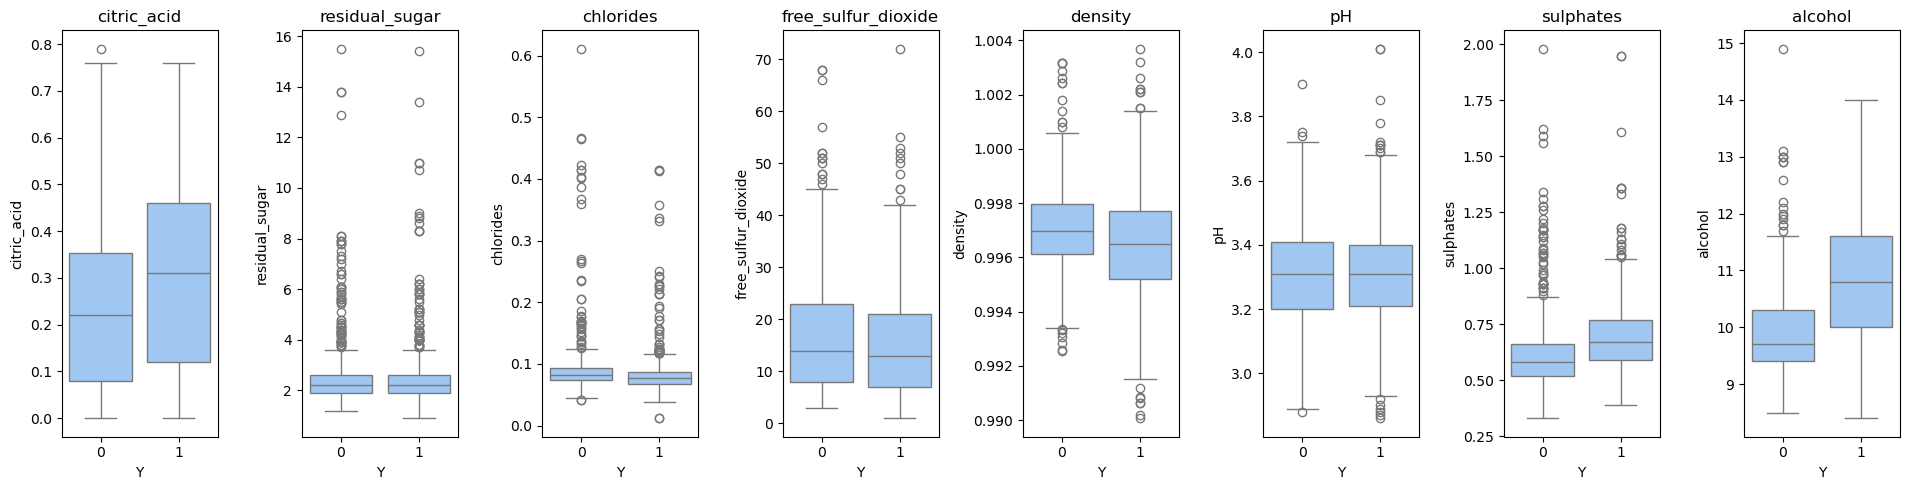

In [12]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(19.2, 5))
gs = mpl.gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
ax6 = plt.subplot(gs[0, 5])
ax7 = plt.subplot(gs[0, 6])
ax8 = plt.subplot(gs[0, 7])
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
cols_loop = list(df.columns[:8].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=df, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в разбросе наблюдается по всем объясняющим переменным кроме citrc_acid, а отличие в медиане - у всех кроме residual_sugar и pH. Классы 0 и 1 переменной Y по большинству объясняющих переменных разделяются, но не сильно.

##### Корреляционный анализ

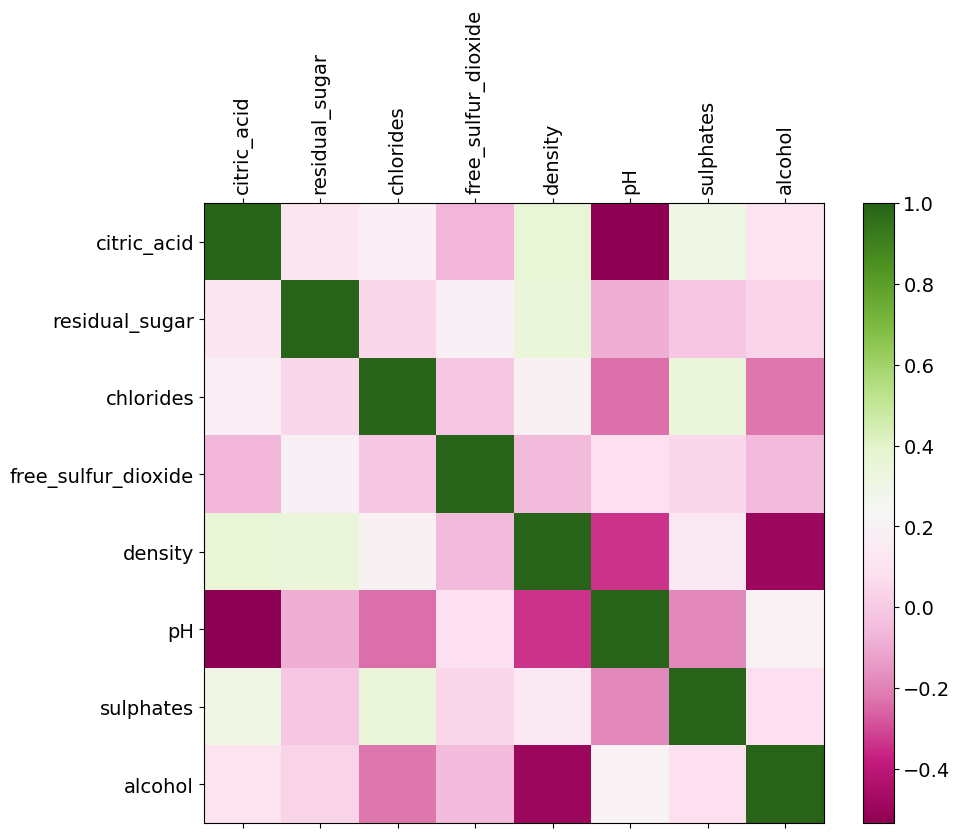

In [13]:
# рассчитываем корреляционную матрицу
corr_mat = df.drop('Y', axis=1).corr()
col_names = df.drop('Y', axis=1).columns
# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Среди достаточно сильных линейных связей наблюдаются только отрицательные. Выведем все значимые коэффициенты в одной таблице, чтобы увидеть предельные.

In [14]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
# и нижний треугольник матрицы
df_corr = corr_mat
df_corr = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
# корреляция
df_corr = df_corr.stack().reset_index()
df_corr.columns = ['Показатель 1', 'Показатель 2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(df.index) - 2) / (1 - df_corr.Корреляция.values ** 2))
df_corr['P-значение'] = 2*(1 - t.cdf(abs(t_stat), len(df.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
# выводим все значимые с сортировкой
df_corr.loc[df_corr['P-значение'] < 0.05].sort_values('Корреляция')

,Показатель 1,Показатель 2,Корреляция,P-значение
4,citric_acid,pH,-0.534086,0.0
24,density,alcohol,-0.492971,0.0
22,density,pH,-0.338291,0.0
15,chlorides,pH,-0.237309,0.0
17,chlorides,alcohol,-0.223580,0.0
25,pH,sulphates,-0.184095,0.0
10,residual_sugar,pH,-0.084909,0.0
2,citric_acid,free_sulfur_dioxide,-0.070947,0.0
21,free_sulfur_dioxide,alcohol,-0.051383,0.0
18,free_sulfur_dioxide,density,-0.049962,0.0


#### Снизить размерность пространства объясняющих переменных методом PLS. Обосновать количество главных компонент. Построить модель логистической регрессии на преобразованном пространстве объясняющих переменных. Оценить точность модели методом перекрёстной проверки.

In [15]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(df.iloc[:, :8].values)
# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
        np.round(np.mean(X_train_std[:, i_col]), 2),
        ' Станд. отклонение = ',
        np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = 0.0 Станд. отклонение = 1.0
Столбец 1: среднее = 0.0 Станд. отклонение = 1.0
Столбец 2: среднее = 0.0 Станд. отклонение = 1.0
Столбец 3: среднее = -0.0 Станд. отклонение = 1.0
Столбец 4: среднее = -0.0 Станд. отклонение = 1.0
Столбец 5: среднее = -0.0 Станд. отклонение = 1.0
Столбец 6: среднее = 0.0 Станд. отклонение = 1.0
Столбец 7: среднее = -0.0 Станд. отклонение = 1.0


In [16]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=8)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(df[['Y']].astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)
# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis = 0) / np.sum(np.var(X_train_std, axis = 0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
    np.around(frac_var_expl, 3),
    '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.165 0.176 0.102 0.071 0.074 0.104 0.076 0.094] 
Общая сумма долей: 0.862


Сначала попробуем сократить количество компонент до 2-х и посмотреть на график, затем проделаем то же самое с 3-мя компонентами.

In [17]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.647837,0.352163
1,0.647947,0.352053
2,0.348308,0.651692
3,0.087068,0.912932
4,0.187261,0.812739
...,...,...
1354,0.572522,0.427478
1355,0.706746,0.293254
1356,0.022260,0.977740
1357,0.417300,0.582700


In [18]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred :
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(0, 716), (1, 643)])

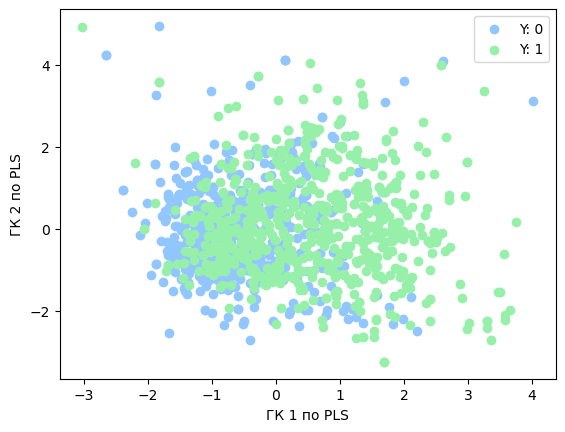

In [19]:
# график классов в пространстве ГК
plt.scatter(X_train_pls[df['Y'] == 0][:, 0],
            X_train_pls[df['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pls[df['Y'] == 1][:, 0],
            X_train_pls[df['Y'] == 1][:, 1], label='Y: 1')
plt.legend()
plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')

plt.show()

In [20]:
# k = 4
pls = PLSRegression(n_components=3)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred :
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])

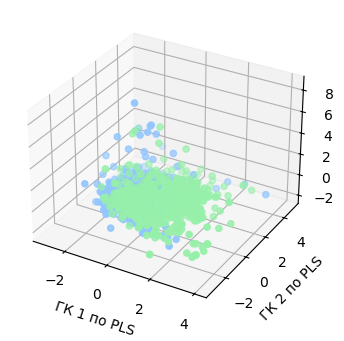

In [21]:
fig = plt.figure(figsize=(7, 4))
ax3d = fig.add_subplot(projection='3d')
ax3d.scatter(X_train_pls[df['Y'] == 0][:, 0],
             X_train_pls[df['Y'] == 0][:, 1],
             X_train_pls[df['Y'] == 0][:, 2], label='Y: 0')
ax3d.scatter(X_train_pls[df['Y'] == 1][:, 0],
             X_train_pls[df['Y'] == 1][:, 1],
             X_train_pls[df['Y'] == 1][:, 2], label='Y: 1')
ax3d.set_xlabel('ГК 1 по PLS')
ax3d.set_ylabel('ГК 2 по PLS')
ax3d.set_zlabel('ГК 3 по PLS')
plt.show()

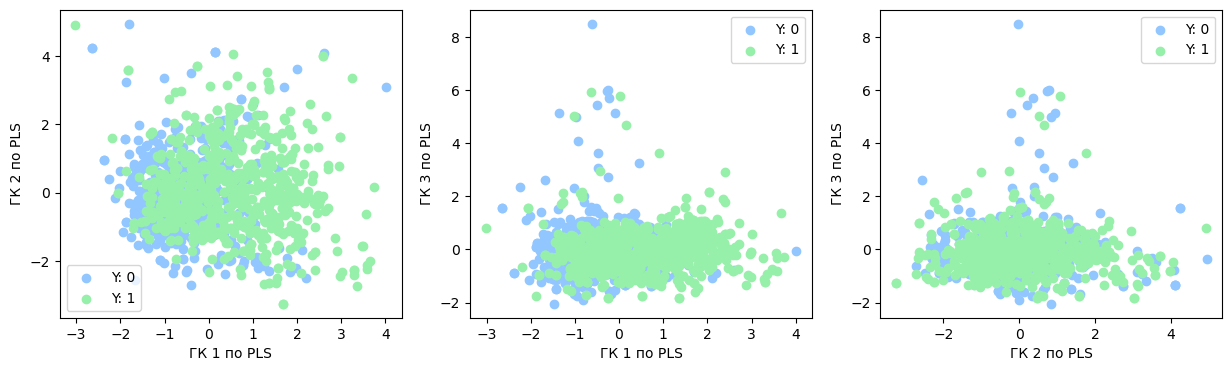

In [22]:
# график классов в пространстве ГК
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.scatter(X_train_pls[df['Y'] == 0][:, 0],
            X_train_pls[df['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pls[df['Y'] == 1][:, 0],
            X_train_pls[df['Y'] == 1][:, 1], label='Y: 1')
plt.legend()
plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')

plt.subplot(1, 3, 2)
plt.scatter(X_train_pls[df['Y'] == 0][:, 0],
            X_train_pls[df['Y'] == 0][:, 2], label='Y: 0')
plt.scatter(X_train_pls[df['Y'] == 1][:, 0],
            X_train_pls[df['Y'] == 1][:, 2], label='Y: 1')
plt.legend()
plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 3 по PLS')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_train_pls[df['Y'] == 0][:, 1],
            X_train_pls[df['Y'] == 0][:, 2], label='Y: 0')
plt.scatter(X_train_pls[df['Y'] == 1][:, 1],
            X_train_pls[df['Y'] == 1][:, 2], label='Y: 1')
plt.legend()
plt.xlabel('ГК 2 по PLS')
plt.ylabel('ГК 3 по PLS')

plt.show()

In [23]:
score = list()
acc_blocks = list()
Y_train = df.Y.values
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
for k in range(1, 7):
    kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
    pls_cv = PLSRegression(n_components=k)
    acc_blocks = list()
    for train_index, test_index in kf_10.split(X_train_std, df.Y.values) :
        X_i_train = X_train_std[train_index]
        Y_i_train = Y_train_dummy.iloc[train_index, :]
        X_i_test = X_train_std[test_index]
        Y_i_test = Y_train[test_index]
        pls_cv.fit(X_i_train, Y_i_train)
        Y_pred = pls_cv.predict(X_i_test)
        Y_hat = list()
        for y_i in Y_pred :
            Y_hat.append(np.argmax(y_i))
        acc = accuracy_score(Y_i_test, Y_hat)
        acc_blocks.append(acc)
    score.append(np.around(np.mean(acc_blocks), 5))
    print('Модель logit_PLS, перекрёстная проверка по 10 блокам, k = ', k,
    '\nAcc = ', np.around(score[k-1], 5), sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам, k = 1
Acc = 0.70491
Модель logit_PLS, перекрёстная проверка по 10 блокам, k = 2
Acc = 0.7071
Модель logit_PLS, перекрёстная проверка по 10 блокам, k = 3
Acc = 0.7071
Модель logit_PLS, перекрёстная проверка по 10 блокам, k = 4
Acc = 0.70416
Модель logit_PLS, перекрёстная проверка по 10 блокам, k = 5
Acc = 0.7049
Модель logit_PLS, перекрёстная проверка по 10 блокам, k = 6
Acc = 0.7049


Как можно видеть, вне зависимости от выбранного количества компонент точность сильно не меняется, и классы оказываются плохо разделимы. Но лучше всего показывает себя k = 3. 

#### Провести регуляризацию модели логистической регрессии методом лассо-регрессии. Подобрать оптимальное значение гиперпараметра методом перекрёстной проверки. Построить график сжатия параметров модели.

In [24]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
    '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [0.23] 
Коэффициенты моделей для классов:
 [[ 0.16  -0.102 -0.276 -0.085 -0.009 -0.123  0.533  1.013]]


In [25]:
# поиск оптимального значения C:
# подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = OneVsRestClassifier(LogisticRegressionCV(cv=10, random_state=my_seed+3, penalty='l1', solver='liblinear'))
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
# точность для каждого класса
lasso_cv.estimators_[0].C_

array([21.5443469])

In [30]:
# сохраняем и выводим Acc для модели
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))
print('Модель logit_lasso, перекрёстная проверка по 10 блокам',
    '\nAcc = ', score[-1], sep='')

Модель logit_lasso, перекрёстная проверка по 10 блокам
Acc = 0.717


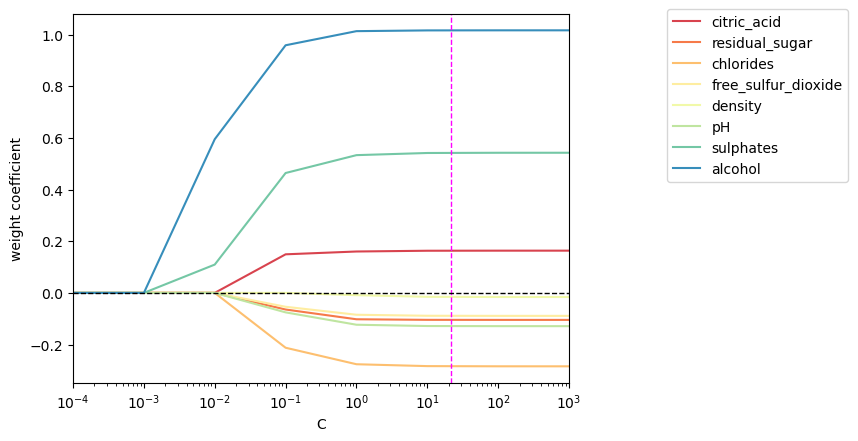

In [28]:
# график динамики коэффициентов в лассо-регрессии
# модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.estimators_[0].C_, df.columns)

Ни один коффициент не обнуляется, но держится в пределах примерно от -0,25 до 1, что подтверждает, что классы слабо-разделимы.

#### Выбрать наиболее точную модель из полученных в пунктах 3 и 4, сделать по ней прогноз на отложенные наблюдения, оценить точность этого прогноза.

Самая точная модель – лассо-регрессия. Сделаем прогноз на отложенные наблюдения.

In [29]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(df_predict.iloc[:, :8].values)
Y_pred = df_predict.Y
Y_hat = logit_lasso.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       108
           1       0.79      0.72      0.75       132

    accuracy                           0.74       240
   macro avg       0.74      0.74      0.74       240
weighted avg       0.75      0.74      0.74       240



После сжатия коэффициентов методом логистической регрессии с L1-регуляризацией точность оказалось примерно 75%, что не идеально, но честная работа..